In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import subprocess, cv2, json, os, sys, shutil, pyk4a, time
import numpy as np, matplotlib.pyplot as plt
from kinectacq.acquisition import start_recording
from kinectacq.paths import DATA_DIR, ensure_dir

### Set up recording location

In [10]:
import datetime

In [11]:
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
timestamp

'2023-01-26_20-06-39'

In [12]:
filename_prefix = DATA_DIR / 'test_recording' / timestamp

In [13]:
ensure_dir(filename_prefix)

### Get camera information

In [14]:
#!k4arecorder --list

Index:0	Serial:000412721712	Color:1.6.110	Depth:1.6.79
Index:1	Serial:000567321712	Color:1.6.110	Depth:1.6.79
Index:2	Serial:000774310512	Color:1.6.110	Depth:1.6.79
Index:3	Serial:000161621712	Color:1.6.110	Depth:1.6.79
Index:4	Serial:000570221712	Color:1.6.110	Depth:1.6.79
Index:5	Serial:000621521712	Color:1.6.110	Depth:1.6.79


In [20]:
device_serials = {
    'S1' : '000570221712',
    'S2' : '000774310512',
    'S3' : '000567321712',
    'S4' : '000621521712',
    'Top' : '000412721712',
    'Bottom' : '000161621712'
}
device_names = {val:key for key, val in device_serials.items()}

In [25]:
from pyk4a import PyK4A, connected_device_count

device_name_id = {}
cnt = connected_device_count()
if not cnt:
    print("No devices available")
    exit()
print(f"Available devices: {cnt}")
for device_id in range(cnt):
    device = PyK4A(device_id=device_id)
    device.open()
    print(f"{device_id}: {device.serial}")
    device_name_id[device_names[device.serial]]= device_id
    device.close()

Available devices: 6
0: 000412721712
1: 000567321712
2: 000774310512
3: 000161621712
4: 000570221712
5: 000621521712


In [26]:
device_name_id

{'Top': 0, 'S3': 1, 'S2': 2, 'Bottom': 3, 'S1': 4, 'S4': 5}

### Set up devices
- each k4a device needs to be configured
- multi-camera rigs need to set up the WiredSyncMode
    - Master = WiredSyncMode.MASTER
    - Subordinate = WiredSyncMode.SUBORDINATE
    - subordinate_delay_off_master_usec=640 (master samples every 900usec)
- [Kinect SDK](https://microsoft.github.io/Azure-Kinect-Sensor-SDK/master/structk4a__device__configuration__t_a8208974f05d89fc1362c6a0900bdef4d.html#a8208974f05d89fc1362c6a0900bdef4d)

In [8]:
from pyk4a import (
    PyK4A,
    Config,
    ColorResolution,
    DepthMode,
    WiredSyncMode,
)

In [ ]:
# set top to master
devices = {
    "Top": {
        "id": device_name_id['Top'],
        "pyk4a_config": {
            "color_resolution": ColorResolution.RES_720P,
            "depth_mode": DepthMode.NFOV_UNBINNED,
            "synchronized_images_only": False,
            "wired_sync_mode": WiredSyncMode.MASTER,
        },
        "process_kwargs": {
            "display_frames": True,
            "display_time": False,
            "save_color": True, 
        },
    }
}

In [9]:
devices = {
    "master": {
        "id": 0,
        "pyk4a_config": {
            "color_resolution": ColorResolution.RES_720P,
            "depth_mode": DepthMode.NFOV_UNBINNED,
            "synchronized_images_only": False,
            "wired_sync_mode": WiredSyncMode.MASTER,
        },
        "process_kwargs": {
            "display_frames": True,
            "display_time": False,
            "save_color": True, 
        },
    },
    "subordinate": {
        "id": 1,
        "pyk4a_config": {
            "color_resolution": ColorResolution.OFF,
            "depth_mode": DepthMode.NFOV_UNBINNED,
            "synchronized_images_only": False,
            "wired_sync_mode": WiredSyncMode.SUBORDINATE,
            "subordinate_delay_off_master_usec" : 640
        },
        "process_kwargs": {
            "display_frames": False,
            "display_time": True,
            "save_color":False,
        },
    }
}

### Set up processing functions
- Functions for reducing video file sizes to 8 bit. 

In [10]:
_dtype = np.uint16

In [11]:
def process_depth(depth):
    #return np.clip((depth - 435) * (depth < 690), 0, 255).astype(_dtype)
    return depth.astype(_dtype)
def process_ir(ir):
    #ir = np.clip(ir + 100, 160, 5500)
    #return ((np.log(ir) - 5) * 70).astype(_dtype)
    return ir.astype(_dtype)

### Recording parameters

In [12]:
ir_depth_write_frames_kwargs={
        "codec": "ffv1", #"ffv1",
        "crf": 14,
        "threads": 6,
        "fps": 30,
        "slices": 24,
        "slicecrc": 1,
        "frame_size": None,
        "get_cmd": False,
    }

In [13]:
color_write_frames_kwargs={
        "codec": "ffv1", #"h264",
        "crf": 22,
        "threads": 6,
        "fps": 30,
        "slices": 24,
        "slicecrc": 1,
        "frame_size": None,
        "get_cmd": False,
    }

In [14]:
recording_duration = 5

### Run recording
- TODO: catch errors in subprocess for multiple cameras

In [15]:
start_recording(
    filename_prefix,
    recording_duration,
    devices=devices,
    depth_function = process_depth,
    ir_function = process_ir,
    #ir_depth_dtype = _dtype,
    #ir_depth_write_frames_kwargs=ir_depth_write_frames_kwargs,
    color_write_frames_kwargs=color_write_frames_kwargs
)

master (frames written):   0%|          | 0/150 [00:00<?, ?it/s]

subordinate (frames written):   0%|          | 0/150 [00:00<?, ?it/s]

[2023-01-26 20:02:57.206] [error] [t=4780] /__w/1/s/extern/Azure-Kinect-Sensor-SDK/src/usbcommand/usbstreaming.c (117): usb_cmd_libusb_cb(). LibUSB transfer status of 00000002 unexpected
[2023-01-26 20:02:57.206] [error] [t=4780] /__w/1/s/extern/Azure-Kinect-Sensor-SDK/src/usbcommand/usbstreaming.c (117): usb_cmd_libusb_cb(). LibUSB transfer status of 00000002 unexpected
[2023-01-26 20:02:57.206] [error] [t=4780] /__w/1/s/extern/Azure-Kinect-Sensor-SDK/src/usbcommand/usbstreaming.c (117): usb_cmd_libusb_cb(). LibUSB transfer status of 00000002 unexpected
[2023-01-26 20:02:57.206] [error] [t=4780] /__w/1/s/extern/Azure-Kinect-Sensor-SDK/src/usbcommand/usbstreaming.c (117): usb_cmd_libusb_cb(). LibUSB transfer status of 00000002 unexpected
[2023-01-26 20:02:57.206] [error] [t=4780] /__w/1/s/extern/Azure-Kinect-Sensor-SDK/src/usbcommand/usbstreaming.c (117): usb_cmd_libusb_cb(). LibUSB transfer status of 00000002 unexpected
[2023-01-26 20:02:57.206] [error] [t=4780] /__w/1/s/extern/Azure-

Recording (s):   0%|          | 0/5 [00:00<?, ?it/s]

capture_from_azure initialized: subordinate 
capture_from_azure initialized: master 
Dropped frame: color
 

QObject::moveToThread: Current thread (0x5651510600e0) is not the object's thread (0x5651503320d0).
Cannot move to target thread (0x5651510600e0)

QObject::moveToThread: Current thread (0x5651510600e0) is not the object's thread (0x5651503320d0).
Cannot move to target thread (0x5651510600e0)

QObject::moveToThread: Current thread (0x5651510600e0) is not the object's thread (0x5651503320d0).
Cannot move to target thread (0x5651510600e0)

QObject::moveToThread: Current thread (0x5651510600e0) is not the object's thread (0x5651503320d0).
Cannot move to target thread (0x5651510600e0)

QObject::moveToThread: Current thread (0x5651510600e0) is not the object's thread (0x5651503320d0).
Cannot move to target thread (0x5651510600e0)

QObject::moveToThread: Current thread (0x5651510600e0) is not the object's thread (0x5651503320d0).
Cannot move to target thread (0x5651510600e0)

QObject::moveToThread: Current thread (0x5651510600e0) is not the object's thread (0x5651503320d0).
Cannot move to tar

 Finished recording: 2023-01-26 20:03:03.284862
 Framerate (subordinate):30.3725
Finished writing (subordinate): 2023-01-26 20:03:03.748370
Framerate (master):30.4282
Finished writing (master): 2023-01-26 20:03:04.395925


### Read and show file

In [16]:
raise ValueError('Break')

ValueError: Break

In [17]:
filename_prefix

PosixPath('/n/groups/datta/tim_sainburg/projects/kinectacq/data/test_recording/2022-02-18_11-32-15')

In [18]:
print('\n'.join([i.as_posix() for i in list(filename_prefix.iterdir())]))

/n/groups/datta/tim_sainburg/projects/kinectacq/data/test_recording/2022-02-18_11-32-15/master
/n/groups/datta/tim_sainburg/projects/kinectacq/data/test_recording/2022-02-18_11-32-15/subordinate


In [19]:
print('\n'.join([i.as_posix() for i in list((filename_prefix/'master').iterdir())]))

/n/groups/datta/tim_sainburg/projects/kinectacq/data/test_recording/2022-02-18_11-32-15/master/color.avi
/n/groups/datta/tim_sainburg/projects/kinectacq/data/test_recording/2022-02-18_11-32-15/master/ir.avi
/n/groups/datta/tim_sainburg/projects/kinectacq/data/test_recording/2022-02-18_11-32-15/master/calibration.json
/n/groups/datta/tim_sainburg/projects/kinectacq/data/test_recording/2022-02-18_11-32-15/master/system_timestamps.npy
/n/groups/datta/tim_sainburg/projects/kinectacq/data/test_recording/2022-02-18_11-32-15/master/depth.avi
/n/groups/datta/tim_sainburg/projects/kinectacq/data/test_recording/2022-02-18_11-32-15/master/device_timestamps.npy


In [20]:
print('\n'.join([i.as_posix() for i in list((filename_prefix/'subordinate').iterdir())]))

/n/groups/datta/tim_sainburg/projects/kinectacq/data/test_recording/2022-02-18_11-32-15/subordinate/calibration.json


In [21]:
file_loc = filename_prefix / 'master' /  "depth.avi"
vidcap = cv2.VideoCapture(file_loc.as_posix())
success,image = vidcap.read()
total_frames = vidcap.get(7)
print(total_frames, image.shape)

148.0 (576, 640, 3)


In [22]:
os.path.getsize(file_loc)

5082234

In [23]:
nbit = 16
total_expected_bits = total_frames * np.product(image.shape) * nbit
total_expected_MB_uncompressed = total_expected_bits * 1.192e-7 
print('uncompressed size: {} MB'.format(round(total_expected_MB_uncompressed)))
print('actual_size: {} MB'.format(round(os.path.getsize(file_loc) * 1e-6)))

uncompressed size: 312 MB
actual_size: 5 MB


In [24]:
# get frame at number
vidcap.set(1, 50)
success,image = vidcap.read()

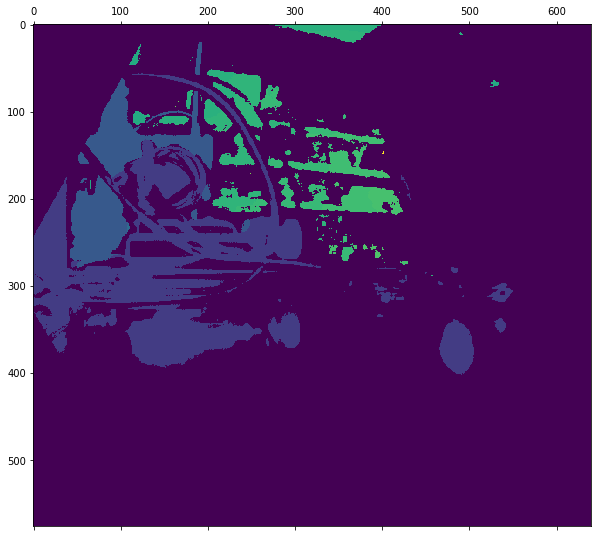

In [25]:
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(np.log(1+image)[:,:,0])

In [26]:
file_loc = filename_prefix / 'master' /  "color.avi"
vidcap = cv2.VideoCapture(file_loc.as_posix())
success,image = vidcap.read()
total_frames = vidcap.get(7)
print(total_frames, image.shape)

146.0 (720, 1280, 3)


In [27]:
nbit = 8
total_expected_bits = total_frames * np.product(image.shape) * nbit
total_expected_MB_uncompressed = total_expected_bits * 1.192e-7 
print('uncompressed size: {} MB'.format(total_expected_MB_uncompressed))
print('actual_size: {} MB'.format(os.path.getsize(file_loc) * 1e-6))

uncompressed size: 384.93093888 MB
actual_size: 79.752962 MB


In [28]:
success,image = vidcap.read()
# get frame at number
vidcap.set(1, 50)
success,image = vidcap.read()

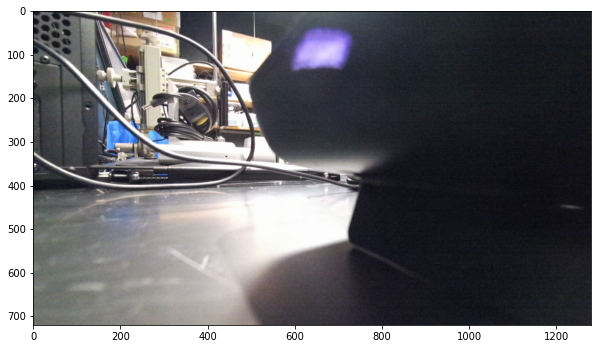

In [29]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(image)